In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")
%matplotlib inline

In [13]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [14]:
path = 'dataset.txt'
df = pd.read_csv(path)
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [15]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: 3.145186
p-value: 1.000000


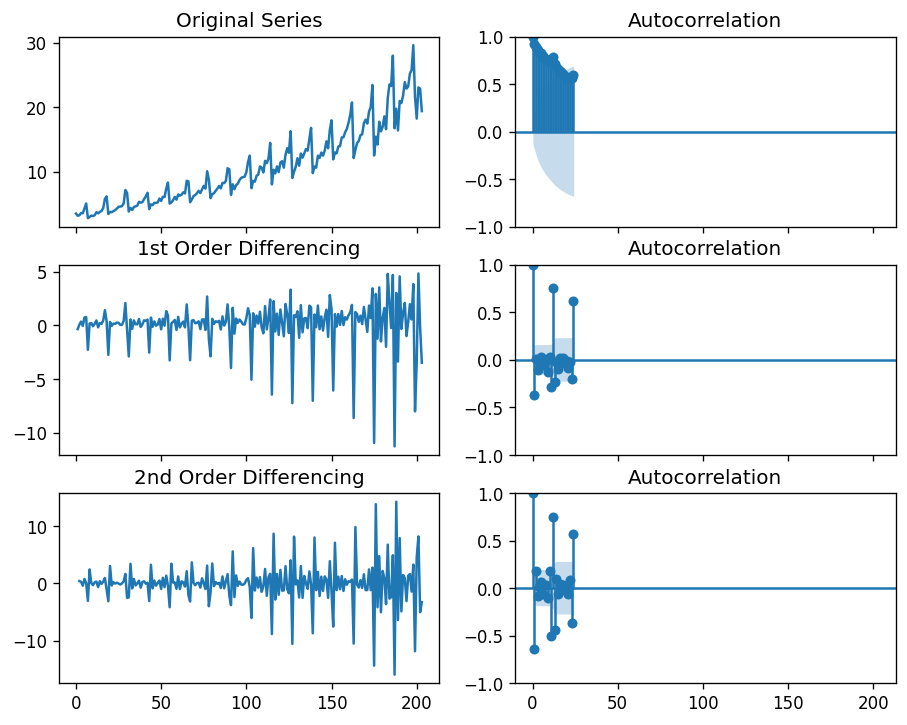

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()


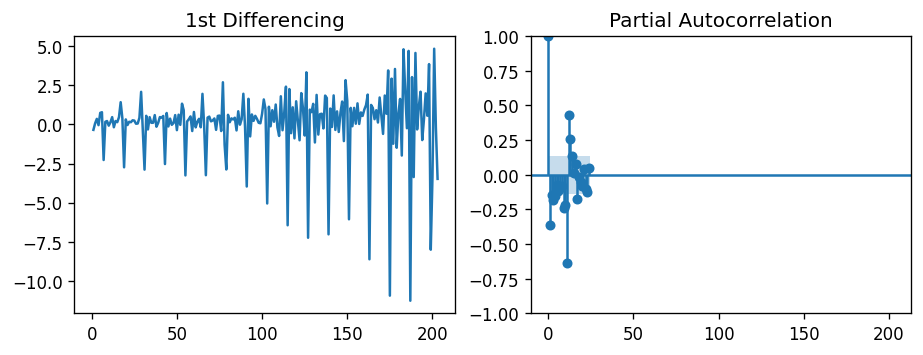

In [17]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()


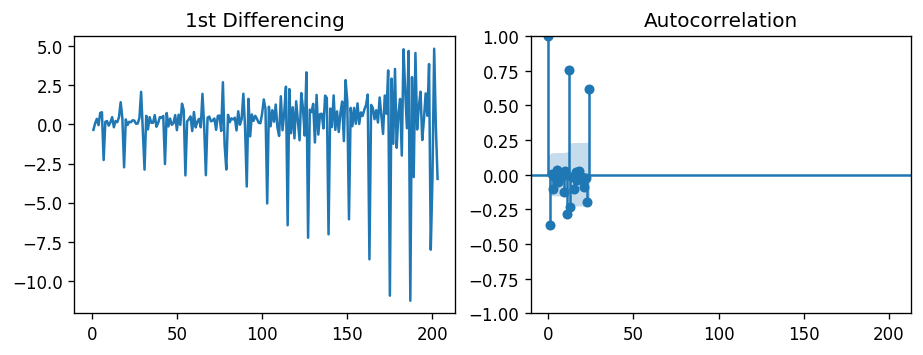

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()


In [22]:
# Build the ARIMA model
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -424.570
Date:                Mon, 28 Oct 2024   AIC                            857.140
Time:                        10:00:51   BIC                            870.393
Sample:                             0   HQIC                           862.502
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4178      0.356      1.174      0.240      -0.280       1.115
ma.L1         -0.9546      0.377     -2.531      0.011      -1.694      -0.215
ma.L2          0.0969      0.272      0.356      0.7

In [24]:
# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -424.762
Date:                Mon, 28 Oct 2024   AIC                            855.524
Time:                        10:01:00   BIC                            865.463
Sample:                             0   HQIC                           859.545
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3009      0.094      3.195      0.001       0.116       0.485
ma.L1         -0.8300      0.048    -17.204      0.000      -0.925      -0.735
sigma2         3.8327      0.259     14.790      0.0

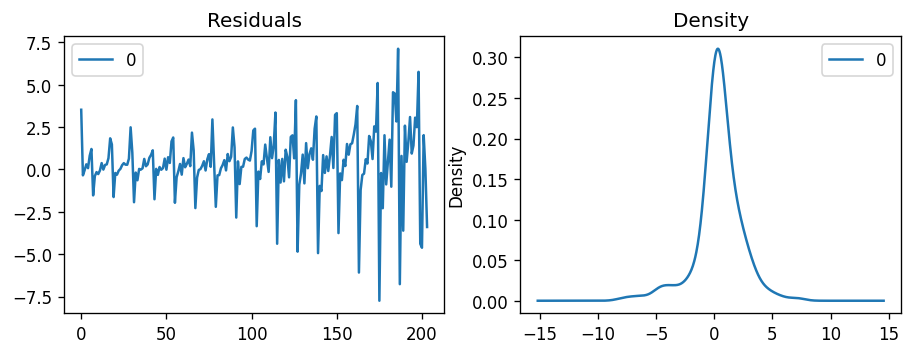

In [25]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

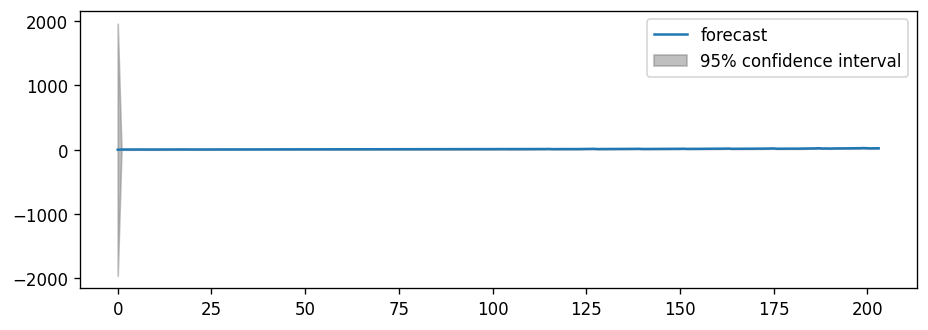

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
# Actual vs Fitted
plot_predict(model_fit)
#model_fit.plot_predict(dynamic=False)
plt.show()

In [31]:
# Find the optimal ARIMA model using Out-of-Time Cross validation
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]

In [43]:
# Build Model
# model = ARIMA(train, order=(3,2,1))
model = ARIMA(train, order=(1, 1, 1))
fitted = model.fit()

# Forecast
fc, se, conf = fitted.forecast(119, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

ValueError: too many values to unpack (expected 3)

In [40]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))
fitted = model.fit(disp=-1)
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(119, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

TypeError: ARIMA.fit() got an unexpected keyword argument 'disp'

In [41]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 119

In [42]:
#Auto Arima Forecasting in Python
!pip install pmdarima

  Using cached Cython-3.0.11-cp312-cp312-win_amd64.whl.metadata (3.2 kB)
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   - ------------------------------------- 20.5/625.1 kB 640.0 kB/s eta 0:00:01
   ----------------- ---------------------- 266.2/625.1 kB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 625.1/625.1 kB 5.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.4/2.8 MB 12.9 MB/s eta 0:00:01
   ------------- -------------------------- 0.9/2.8 MB 11.8 MB/s eta 0:00:01
   -------------------- ------------------- 1.4/2.8 MB 12.8 MB/s eta 0:00:01
   ---------------------------- ----------- 2.0/2.8 MB 14.1 MB/s eta 0:00:01
   ---------------------------------------  2.7/2.8 MB 15.8 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 13.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=874.416, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1602.665, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=913.571, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1392.713, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=865.809, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=867.147, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=871.437, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=868.483, Time=0.22 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=858.292, Time=0.70 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.73 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=859.374, Time=1.92 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=860.862, Time=2.10 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit 

c:\users\administrator\pycharmprojects\arima_timeseries\venv\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


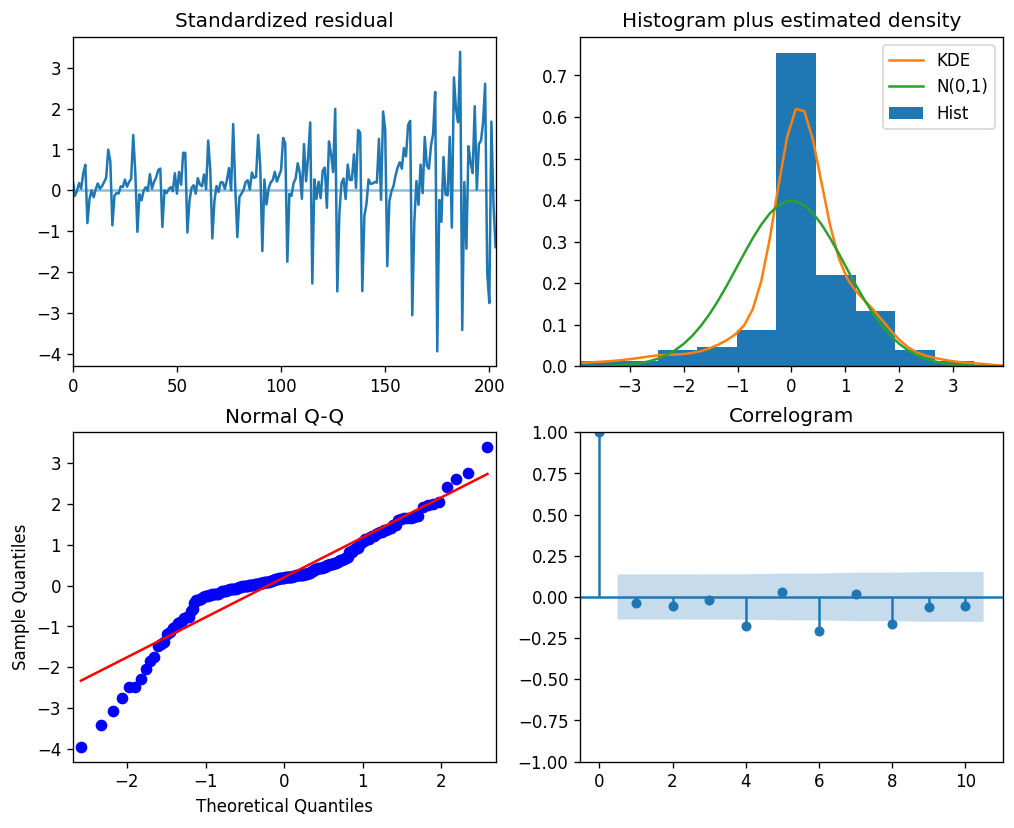

In [19]:
#How to interpret the residual plots in ARIMA model
model.plot_diagnostics(figsize=(10,8))
plt.show()

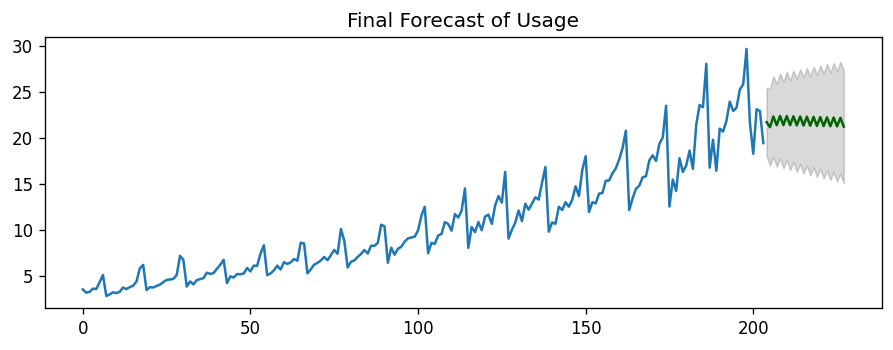

In [20]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)

plt.title("Final Forecast of Usage")
plt.show()

SARIMA model in python

In [21]:
data = pd.read_csv('C:/Users/Administrator/PycharmProjects/ARIMA_TimeSeries/dataset.txt', parse_dates=['date'], index_col='date')

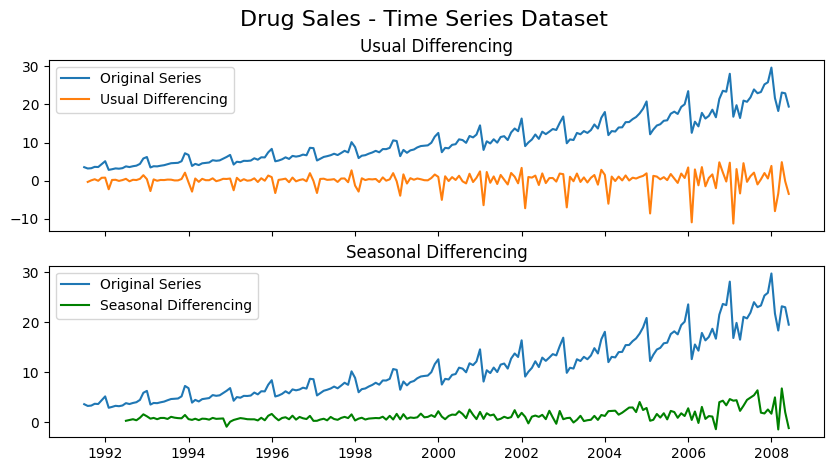

In [22]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Drug Sales - Time Series Dataset', fontsize=16)
plt.show()

In [23]:
# !pip3 install pyramid-arima (already done)
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=1.95 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.38 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.24 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=4.61 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=1.05 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.797, Time=4.35 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.40 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=1.34 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.27 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  204
Model:             SARIMAX(2, 0, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -254.176
Date:                                 Wed, 05 May 2021   AIC                            522.352
Time:                                         00:51:02   BIC                            545.155
Sample:                                              0   HQIC                           531.588
                                                 - 204                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6750      0.068      9.958      0.000       0.542       0.808
ar.L2          0.3149      0.063      4.993      0.000       0.191       0.439
ma.L1         -0.6390      0.062    -10.333      0.000      -0.760      -0.518
ar.S.L12       0.8484      0.152      5.575      0.000       0.550       1.147
ma.S.L12      -1.5857      0.174     -9.125      0.000      -1.926      -1.245
ma.S.L24       0.7618      0.109      6.980      0.000       0.548       0.976
sigma2         0.7455      0.068     10.988      0.000       0.613       0.879
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               197.88
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):              15.44   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

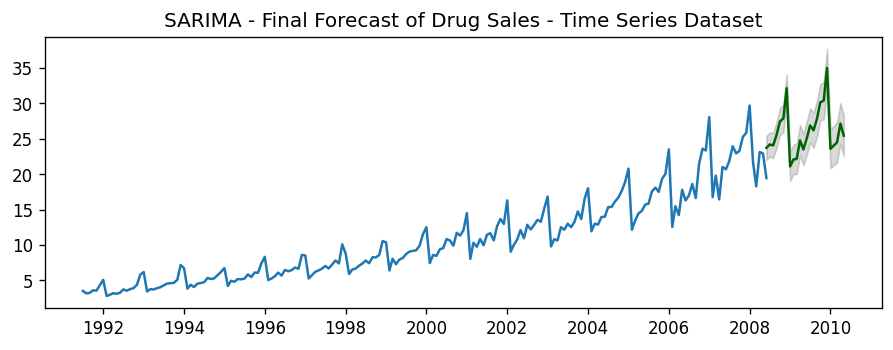

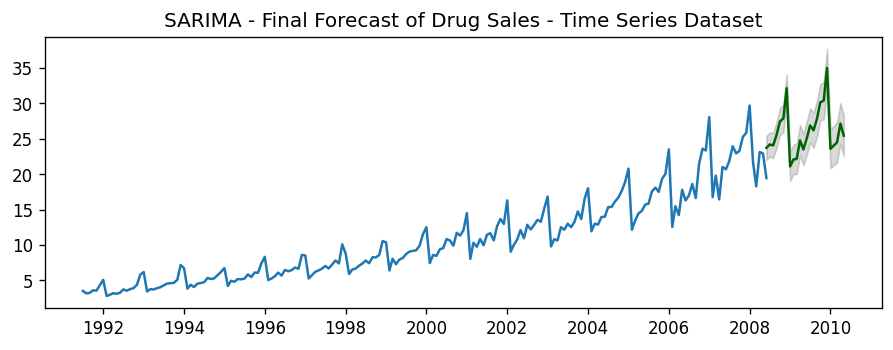

In [25]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Drug Sales - Time Series Dataset")
plt.show()

In [26]:
# SARIMAX model with exogeneous variables
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative',
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index

In [27]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=536.818, Time=2.51 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=626.061, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=598.068, Time=0.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=613.475, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=759.274, Time=0.12 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=561.407, Time=0.37 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=538.817, Time=4.48 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=545.106, Time=2.28 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=539.873, Time=6.17 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=596.467, Time=0.29 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=531.829, Time=1.10 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=557.198, Time=0.34 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.31 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -253.951
Date:                            Wed, 05 May 2021   AIC                            525.903
Time:                                    00:53:59   BIC                            555.220
Sample:                                07-01-1991   HQIC                           537.776
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0052      0.009      0.578      0.563      -0.012       0.023
seasonal_index  1.323e-06   4665.913   2.83e-10      1.000   -9145.021    9145.021
ar.L1              0.9767      0.018     52.998      0.000       0.941       1.013
ma.L1             -0.9114      0.057    -16.071      0.000      -1.023      -0.800
ma.L2              0.2163      0.059      3.677      0.000       0.101       0.332
ar.S.L12           0.8424      0.155      5.438      0.000       0.539       1.146
ma.S.L12          -1.5847      0.176     -8.980      0.000      -1.931      -1.239
ma.S.L24           0.7673      0.111      6.905      0.000       0.550       0.985
sigma2             0.7468      0.066     11.344      0.000       0.618       0.876
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               142.55
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):              14.49   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

End